# Paper Figures: Single School, Strategic Student Test Taking 

Figures 5 and 6

 

In [ ]:
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import seaborn as sns


from collections import defaultdict
import re
import ast  # Required to convert string representation of list to list
import itertools



from ipywidgets import IntProgress
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pipeline


import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


from pipeline_cost_run_multiple_instances import run_cost_model_different_costs, defaultdict_converter, literal_converter


In [16]:
simulation_data_folder = 'simulation_data_cost_model_single_school/'
simulation_data_path = simulation_data_folder
figure_data_folder = 'visualization/ms_revision_plots_2025/'
figure_data_path = figure_data_folder

if not os.path.exists(simulation_data_path):
    os.makedirs(simulation_data_path, exist_ok=True)
if not os.path.exists(figure_data_path):
    os.makedirs(figure_data_path, exist_ok=True)



# Generate Figure 5

Plot P(apply | skill, group) for different values of skill.

Figure caption: 
- We consider a case where Group A has higher precision and lower test costs.
- Parameters are $\mu_{gk} = 0$ for all $g,k$,
$\sigma^2_{A1} = \sigma^2_{A2} = \sigma^2_{B1} = 1$ and $\sigma^2_{B2} = 2$, where $k=2$ denotes the test feature. 
Costs are $c_A = 0.5$ and $c_B = 3$. 
- In this case, Group A students are more likely to take the test than Group B students of the same true skill value.


### Main parameters

In [17]:

num_thresholds = 250
num_students=10000

main_student_parameters = {
    "SIMULATION_TYPE": "SINGLE_SCHOOL_COST_MODEL" ,
    'NUM_STUDENTS' : num_students,
    "NUM_SCHOOL_TYPES": 1,
    "FRACTIONS_SCHOOL_TYPES": [1],
    "NUM_SCHOOLS": 1,
    'CAPACITY' : .1,
    "NUM_FEATURES": 2,
    "NUM_GROUPS": 2,
    "FRACTIONS_GROUPS": [0.5, 0.5],
    "TRUESKILL_DIST": ("NORMAL", 0, 1),  # Distribution, mean, variance
    
    "FEATURE_DIST": ("NORMAL", 0, 1),
    "FEATURE_DIST_A0": ("NORMAL", 0, 1),
    "FEATURE_DIST_A1": ("NORMAL", 0, 1),
    "FEATURE_DIST_B0": ("NORMAL", 0, 1),  # FEATURE 0, GROUP B
    "FEATURE_DIST_B1": ("NORMAL", 0, 2),  # FEATURE 1, GROUP B
    
    'BINARY_SEARCH_NUM_THRESHOLDS': num_thresholds,
    'STUDENT_UTILITY': 5, 
    "FEATURES_TO_USE_a":0,
}

In [18]:
cost_parameters = {
    'BINARY_SEARCH_NUM_THRESHOLDS': num_thresholds,
    'STUDENT_UTILITY': 5, 
}

In [19]:
#### RUN ONCE
parameters = {}
students_dfs_all = {}
params_dfs_all = {}
schools_dfs_all = {}

drop_schools_dfs_all = {}
drop_students_dfs_all = {}
drop_params_dfs_all = {}

### Setting where groups have different costs

In [20]:
A0_var = 1
A1_var = 1
B0_var = 1

tolerance = 0.1
B1_stepsize = 0.5
B1_max = 2

costs = {}
costs["A"] = 0.5
cost_A = 0.5
cost_stepsize = 0.25
utility = cost_parameters['STUDENT_UTILITY']

In [21]:
cost_Bs = [3]
B1s = [1]


In [22]:
n_runs = 10

for i in range(n_runs):
    for (B1_var, cost_B) in itertools.product(B1s, cost_Bs):
        instance_params = main_student_parameters.copy()
        instance_params["FEATURE_DIST_A0"] = ("NORMAL", 0, A0_var)
        instance_params["FEATURE_DIST_A1"] = ("NORMAL", 0, A1_var)
        instance_params["FEATURE_DIST_B0"] = ("NORMAL", 0, B0_var)
        instance_params["FEATURE_DIST_B1"] = ("NORMAL", 0, B1_var)
        
        instance_params["STUDENT_TEST_COST"] = {"A": cost_A, "B":cost_B}
        
        
        instance_name = ("A0_{}_A1_{}_B0_{}_B1_{}_costA_{}_costB_{}_N_{}_run_{}"
                        .format(A0_var, A1_var, B0_var, B1_var, cost_A, cost_B, num_students, i))
        parameters[instance_name] = instance_params

In [23]:
parameters[instance_name]

{'SIMULATION_TYPE': 'SINGLE_SCHOOL_COST_MODEL',
 'NUM_STUDENTS': 10000,
 'NUM_SCHOOL_TYPES': 1,
 'FRACTIONS_SCHOOL_TYPES': [1],
 'NUM_SCHOOLS': 1,
 'CAPACITY': 0.1,
 'NUM_FEATURES': 2,
 'NUM_GROUPS': 2,
 'FRACTIONS_GROUPS': [0.5, 0.5],
 'TRUESKILL_DIST': ('NORMAL', 0, 1),
 'FEATURE_DIST': ('NORMAL', 0, 1),
 'FEATURE_DIST_A0': ('NORMAL', 0, 1),
 'FEATURE_DIST_A1': ('NORMAL', 0, 1),
 'FEATURE_DIST_B0': ('NORMAL', 0, 1),
 'FEATURE_DIST_B1': ('NORMAL', 0, 1),
 'BINARY_SEARCH_NUM_THRESHOLDS': 250,
 'STUDENT_UTILITY': 5,
 'FEATURES_TO_USE_a': 0,
 'STUDENT_TEST_COST': {'A': 0.5, 'B': 3}}

In [24]:
len(list(parameters.keys()))

10

### Run simulations not yet run

In [25]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]
if '.ipynb_checkpoints' in instances_done: instances_done.remove('.ipynb_checkpoints')

num_instances_to_run = len(set(list(parameters.keys())) - set(instances_done))
num_instances_to_run

0

In [ ]:
# progress bar
f = IntProgress(min=0, max=num_instances_to_run)
display(f)

for instance in parameters.keys():
    if instance not in instances_done:
        print(instance)
            
        instance_folder = simulation_data_path+instance
        
        
        students_df, schools_df, params_df = pipeline.pipeline(parameters[instance])
        students_dfs_all[instance] = students_df
        schools_dfs_all[instance] = schools_df
        params_df = pd.Series(params_df)
        params_dfs_all[instance] = params_df
        
        
        params_no_test = parameters[instance].copy()
        params_no_test["SIMULATION_TYPE"] = "SINGLE_SCHOOL"
        params_no_test['FEATURES_TO_USE_a'] = -1

        drop_students_df, drop_schools_df, drop_params_df = pipeline.pipeline(params_no_test)
        drop_params_df = pd.Series(drop_params_df)
        
        drop_students_dfs_all[instance] = drop_students_df
        drop_schools_dfs_all[instance] = drop_schools_df
        drop_params_dfs_all[instance] = drop_params_df
        
        os.makedirs(instance_folder, exist_ok=True)
        df_cost_names = ['students_df', 'schools_df', 'params_df']
        df_no_test_names = ['drop_students_df', 'drop_schools_df', 'drop_params_df']
        for df_name in df_cost_names:
            globals()[df_name].to_csv("{}/{}.csv".format(instance_folder, df_name))
        for df_name in df_no_test_names:
            globals()[df_name].to_csv("{}/{}.csv".format(instance_folder, df_name))
            
        f.value += 1


### Read in simulations already run

In [8]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]
if '.ipynb_checkpoints' in instances_done: instances_done.remove('.ipynb_checkpoints')
#instances_done

In [9]:
# Read in data - testing
t_students_dfs_all = {}
t_params_dfs_all = {}
t_schools_dfs_all = {}

t_drop_schools_dfs_all = {}
t_drop_students_dfs_all = {}
t_drop_params_dfs_all = {}

In [10]:
columns_to_convert = ['admitted_students',
                      'prob_apply_rawskill_A', 'avgadmittedtestscore_B', 'prob_apply_test_B',
                    'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 
                      'prob_apply_rawskill_B', 'prob_apply_test_A',
                    'prob_apply_skill_A', 'avgadmittedskill', 'IF', 'IF_rawskill',
                    'prob_apply_skill_B',]

In [11]:
dict_columns = ['IF', 'IF_rawskill']


In [12]:
defaultdict_columns = ['prob_apply_rawskill_A', 'prob_apply_test_B',
'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 'prob_apply_rawskill_B', 'prob_apply_test_A',
'prob_apply_skill_A', 
'prob_apply_skill_B']

converters = {col: literal_converter for col in dict_columns}
converters.update({col: defaultdict_converter for col in defaultdict_columns})
converters['admitted_students'] = literal_converter

In [98]:
students_dfs_all = defaultdict(dict)
schools_dfs_all = defaultdict(dict)
params_dfs_all = defaultdict(dict)

drop_students_dfs_all = defaultdict(dict)
drop_schools_dfs_all = defaultdict(dict)
drop_params_dfs_all = defaultdict(dict)

cost_Bs = {}

for instance in instances_done:
    directory_path = simulation_data_path+instance
    
    # Extract the cost value and data type from the filename
    pattern = r'[^_]+_costB_([^_]+)$'
    # Match the filename pattern
    match = re.search(pattern, instance)
    if match:
        cost_B = match.group(1)
        cost_Bs[instance] = cost_B

    for file_type in ['params_df', 'schools_df', 'students_df']:
        file_path = os.path.join(directory_path, file_type)+".csv"
        df = pd.read_csv(file_path, index_col=0, 
                         converters=converters)
        if file_type == 'students_df': #define coarse skillcut
            # bucket students into skill bins
            roundmult=5
            df.loc[:, "skillcut_coarse"] = (df.skill.rank(pct=True) * roundmult).round(1) / roundmult
        globals()[file_type+"s_all"][instance] = df
        
    
    
    drop_params_dfs_all[instance] = (pd.read_csv(directory_path+"/drop_params_df.csv", 
                                                index_col=0,
                                                converters={'0': literal_converter}
                                               )
                                    )
    drop_students_dfs_all[instance] = pd.read_csv(directory_path+"/drop_students_df.csv", 
                                                  index_col=0)
    drop_schools_dfs_all[instance] = pd.read_csv(directory_path+"/drop_schools_df.csv", 
                                                 converters=converters,
                                                 index_col=0)
        
        

### Plot

In [97]:
instances_subset = [instance for instance in instances_done
                    if "A0_1_A1_1_B0_1_B1_2_costA_0.5_costB_3_N_10000_run_" in instance]

In [92]:
# For each run, calculate P(apply | skill, group) for each group,
# by looking at average across students within the run.
# Return a dictionary indexed by group, with P(apply|skill,group) across runs.

avg_p_apply_df_by_group = defaultdict(dict)
for group in ['A', 'B']:
    for instance in instances_subset:
        avg_p_apply_df_by_group[group][instance] = (students_dfs_all[instance]
                                                    .query('group==@group')
                                                    .groupby('skillcut_coarse')
                                                    .mean(numeric_only=True)
                                                    ['take_test_at_threshold']
                                                )
    avg_p_apply_df_by_group[group] = pd.DataFrame(avg_p_apply_df_by_group[group])

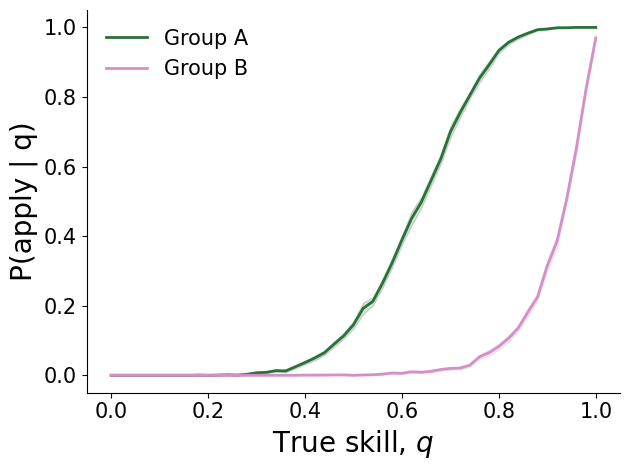

In [102]:

sns.set_palette(sns.color_palette("cubehelix", 2))
plt.figure()
for group in ['A', 'B']:
    # Calculate mean and standard error
    mean = avg_p_apply_df_by_group[group].mean(axis=1)
    yerr = 2*avg_p_apply_df_by_group[group].std(axis=1)/np.sqrt(len(avg_p_apply_df_by_group[group].index))
    
    # Plot mean line
    line = plt.plot(mean.index, mean.values, label=f"Group {group}", linewidth=2)[0]
    color = line.get_color()
    
    # Add shaded error region
    plt.fill_between(mean.index, 
                    mean - yerr,
                    mean + yerr,
                    alpha=0.2, # Transparency of shaded region
                    color=color)
plt.tick_params(axis='both', labelsize=15)
    

plt.legend(frameon=False, fontsize=15)
plt.xlabel("True skill, $q$",fontsize=20)
plt.ylabel("P(apply | q)", fontsize=20)
plt.tight_layout()
plt.savefig(figure_data_path+"p_apply_by_skill_group.png", dpi=300)

# Generate Figure 6

Admission outcomes (average admitted skill, diversity level, and individual fairness gap). 

Fixes variance of all features to be equal, except for test score, which is varied for Group B. Also varies cost of test for Group B. 

Figure Caption
 - Figures 6a and 6b fix cost $c_A = 0.5$ and vary $c_B$. 
 - Academic merit and diversity are particularly harmed when the test is costly and informative for Group B. 
 - Figure 6c considers a fixed cost $c_B = 3$ and shows that individual fairness is worse when the test is more informative for Group B. 
 - The full parameter set can be found in Appendix EC.4.1. 
 - Overall, when the test is informative (low feature variance), higher costs for group B correspond to worse outcomes across all metrics.


In [116]:
simulation_data_path = 'simulation_data_cost_model_single_school_fix_A1_equal_B1/'
figure_data_path = 'visualization/ms_revision_plots_2025/'

if not os.path.exists(simulation_data_path):
    os.makedirs(simulation_data_path)
if not os.path.exists(figure_data_path):
    os.makedirs(figure_data_path)

In [117]:


parameters = {}
students_dfs_all = {}
params_dfs_all = {}
schools_dfs_all = {}

drop_schools_dfs_all = {}
drop_students_dfs_all = {}
drop_params_dfs_all = {}

### Parameters

In [105]:

num_thresholds = 300
num_students = 5000

main_student_parameters = {
    "SIMULATION_TYPE": "SINGLE_SCHOOL_COST_MODEL" ,
    'NUM_STUDENTS':num_students, 
    "NUM_SCHOOL_TYPES": 1,
    "FRACTIONS_SCHOOL_TYPES": [1],
    "NUM_SCHOOLS": 1,
    'CAPACITY' : .1,
    "NUM_FEATURES": 2,
    "NUM_GROUPS": 2,
    "FRACTIONS_GROUPS": [0.5, 0.5],
    "TRUESKILL_DIST": ("NORMAL", 0, 1),  # Distribution, mean, variance
    'STUDENT_UTILITY': 5, 
    'CAPACITY': 0.1, 
    'BINARY_SEARCH_NUM_THRESHOLDS': num_thresholds,
}

In [106]:
# Vary cost_B
costs_B = (np.arange(0, main_student_parameters['STUDENT_UTILITY']-.1,
                   0.25)
        .round(2))
costs_B

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])

In [107]:
num_runs = 50
A0_var = 1
B0_var = 1
tolerance = 0.1
B1_range = 1
B1_stepsize = 0.2
A1_var = 1
B1s = [1, 4]


cost_A = 0.5
cost_pairs = [(cost_A, cost_B) for cost_B in costs_B]

# Add all parameters (A0, A1, B0, B1) as instances to run
for run in range(num_runs):
    for B1_var in B1s:
        #for cost_B in costs_B:
        instance_params = main_student_parameters.copy()
        instance_params["FEATURE_DIST_A0"] = ("NORMAL", 0, A0_var)
        instance_params["FEATURE_DIST_A1"] = ("NORMAL", 0, A1_var)
        instance_params["FEATURE_DIST_B0"] = ("NORMAL", 0, B0_var)
        instance_params["FEATURE_DIST_B1"] = ("NORMAL", 0, B1_var)
        instance_name = "A0_{}_A1_{}_B0_{}_B1_{}_N_{}_run_{}".format(A0_var, A1_var, B0_var, B1_var, num_students, run)
        parameters[instance_name] = instance_params

### Run simulations not yet run

In [ ]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]

instances_done

In [ ]:
for instance in parameters.keys():
    if instance not in instances_done:
        print(instance)
            
        instance_folder = simulation_data_path+instance
        
        students_df, schools_df, params_df = run_cost_model_different_costs(parameters[instance],
                                                                           cost_pairs)
        students_dfs_all[instance] = students_df
        schools_dfs_all[instance] = schools_df
        params_dfs_all[instance] = params_df
    
        
        os.makedirs(instance_folder, exist_ok=True)
        df_cost_names = ['students_df', 'schools_df', 'params_df']
        
        for df_name in df_cost_names:

            for c in cost_pairs:
                globals()[df_name][c].to_csv("{}/{}_cost_{}.csv".format(instance_folder, df_name, c))


### Read in simulations already run

In [119]:
instances_done = [f.name for f in os.scandir(simulation_data_path) if f.is_dir()]

In [120]:
columns_to_convert = ['admitted_students',
                      'prob_apply_rawskill_A', 'avgadmittedtestscore_B', 'prob_apply_test_B',
                    'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 
                      'prob_apply_rawskill_B', 'prob_apply_test_A',
                    'prob_apply_skill_A', 'avgadmittedskill', 'IF', 'IF_rawskill',
                    'prob_apply_skill_B',]

dict_columns = ['IF', 'IF_rawskill']

defaultdict_columns = ['prob_apply_rawskill_A', 'prob_apply_test_B',
'prob_apply_rawtest_A', 'prob_apply_rawtest_B', 'prob_apply_rawskill_B', 'prob_apply_test_A',
'prob_apply_skill_A', 
'prob_apply_skill_B']

In [ ]:
students_dfs_all = defaultdict(dict)
schools_dfs_all = defaultdict(dict)
params_dfs_all = defaultdict(dict)

drop_students_dfs_all = defaultdict(dict)
drop_schools_dfs_all = defaultdict(dict)
drop_params_dfs_all = defaultdict(dict)

costs_all = {}


for instance in instances_done:
    print(instance)

    pattern = r'^([a-z]+)_df_cost_([\d.]+)?\.csv$'
    
    # # Pattern for files with tuple costs like "students_df_cost_(0.5,1.0).csv"
    #tuple_pattern = r'^([a-z]+)_df_cost_\(([\d.]+),([\d.]+)\)\.csv$'
    # Define the pattern for tuple costs with optional spaces
    tuple_pattern = r"^([a-z]+)_df_cost_\(\s*([\d.]+)\s*,\s*([\d.]+)\s*\)\.csv$"
    directory_path = simulation_data_path+instance
    costs = []
    
    # Iterate over the files in the directory
    for filename in os.listdir(directory_path):
        # Match the filename pattern
        match = re.match(pattern, filename)
        match_tuple = re.match(tuple_pattern, filename)
        # Check if the filename matches the pattern
        if match:
            # Extract the cost value and data type from the filename
            data_type = match.group(1)
            #cost_value = int(match.group(2))
            cost_value = float(match.group(2))
            costs.append(cost_value)
            

            # Read the data from the file
            file_path = os.path.join(directory_path, filename)
            converters = {col: literal_converter for col in dict_columns}
            converters.update({col: defaultdict_converter for col in defaultdict_columns})
            converters['admitted_students'] = literal_converter
            df = pd.read_csv(file_path, index_col=0, 
                             converters=converters)

            # Store the data in the corresponding dictionary based on data type
            if data_type == 'students':
                students_dfs_all[instance][cost_value] = df
            elif data_type == 'schools':
                schools_dfs_all[instance][cost_value] = df
            elif data_type == 'params':
                params_dfs_all[instance][cost_value] = df
        
        elif match_tuple:
            # Extract the cost values and data type from the filename
            data_type = match_tuple.group(1)
            cost_A = float(match_tuple.group(2))
            cost_B = float(match_tuple.group(3))
            costs.append((cost_A, cost_B))

            # Read the data from the file
            file_path = os.path.join(directory_path, filename)
            converters = {col: literal_converter for col in dict_columns}
            converters.update({col: defaultdict_converter for col in defaultdict_columns})
            converters['admitted_students'] = literal_converter
            df = pd.read_csv(file_path, index_col=0, converters=converters)

            # Store the data in the corresponding dictionary based on data type
            if data_type == 'students':
                students_dfs_all[instance][(cost_A, cost_B)] = df
            elif data_type == 'schools':
                schools_dfs_all[instance][(cost_A, cost_B)] = df
            elif data_type == 'params':
                params_dfs_all[instance][(cost_A, cost_B)] = df
                
    if isinstance(costs[0], tuple):
        costs_all[instance] = list(set(costs))
    else:
        costs_all[instance] = np.unique(np.array(costs))

  

### Calculate metrics

In [163]:
instances_to_plot = list(params_dfs_all.keys())
instances_to_plot = [instance for instance in instances_to_plot 
                     if 'N_5000' in instance]

instances_B1_1 = [instance for instance in instances_to_plot 
                     if 'B1_1' in instance]
instances_B1_4 = [instance for instance in instances_to_plot 
                     if 'B1_4' in instance]

instances_to_plot = instances_B1_1 + instances_B1_4

In [164]:
metrics = ['frac_A', 
           'avgadmittedskill']


In [167]:

metrics_dfs = defaultdict(dict)
for instance in instances_to_plot:

    for metric in metrics:
        metrics_dfs[instance][metric] = pd.Series({c:schools_dfs_all[instance][c][metric][0] 
                                                    for c in costs_all[instance]}, 
                                        name=metric)
    metrics_dfs[instance] = pd.DataFrame(metrics_dfs[instance]).T

metrics_error_bars = defaultdict(dict)
metrics_error_bars_drop = defaultdict(dict)
z = 1.96

for instance in instances_done:
    metrics_error_bars[instance]['frac_A'] = 0
    
    metrics_error_bars[instance]['avgadmittedskill'] = pd.Series({c:z*(students_dfs_all[instance][c].loc[schools_dfs_all[instance][c]['admitted_students'][0]]['feature_1'].sem())
                                                                 for c in costs_all[instance]}
                                                                  )


### Plot

In [ ]:
cost_A = 0.5

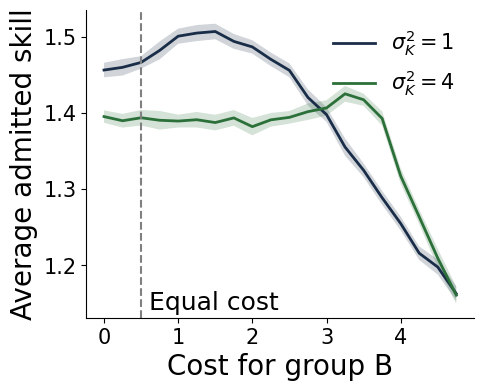

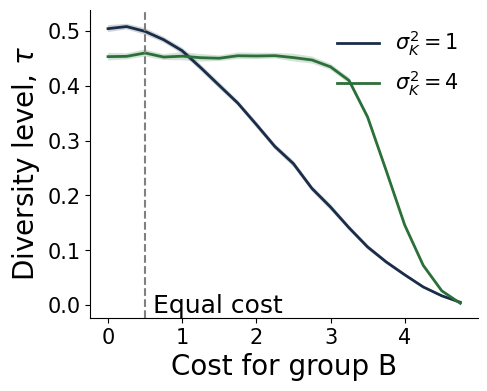

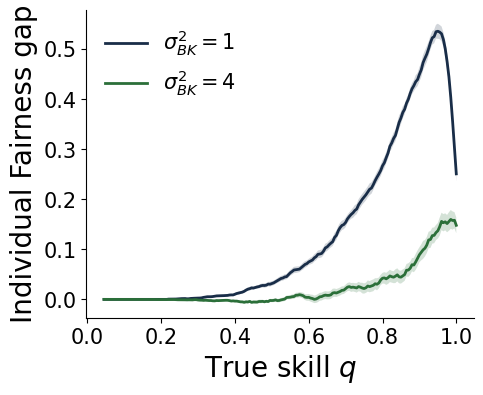

In [231]:
B1_1_diversity = (1-pd.DataFrame({instance: metrics_dfs[instance].loc['frac_A'] for instance in instances_B1_1}))
B1_4_diversity = (1-pd.DataFrame({instance: metrics_dfs[instance].loc['frac_A'] for instance in instances_B1_4}))

B1_1_avgskill = pd.DataFrame({instance: metrics_dfs[instance].loc['avgadmittedskill'] for instance in instances_B1_1})
B1_4_avgskill = pd.DataFrame({instance: metrics_dfs[instance].loc['avgadmittedskill'] for instance in instances_B1_4})

metric_pretty_names = {'avgadmittedskill': 'Average admitted skill',
                       'frac_A': 'Diversity level, $\\tau$ '}



sns.set_palette(sns.color_palette("cubehelix", 5))
for i, metric in enumerate(['avgadmittedskill', 'frac_A']):
    fig, axes = plt.subplots(1,1, figsize=(5,4))
    
    B1_1_metric = ((pd.DataFrame({instance: metrics_dfs[instance].loc[metric] 
                                 for instance in instances_B1_1}))
                   
                   .dropna(axis=1)
                   .loc[cost_A]
                   )
    B1_4_metric = ((pd.DataFrame({instance: metrics_dfs[instance].loc[metric] 
                                 for instance in instances_B1_4}))
                   .dropna(axis=1)
                   .loc[cost_A]
                   )
    if metric == 'frac_A':
        B1_1_metric = (1-B1_1_metric)
        B1_4_metric = (1-B1_4_metric)
    
    B1_1_metric.mean(axis=1).plot(ax=axes, label="$\sigma_K^2=1$", linewidth=2)
    B1_4_metric.mean(axis=1).plot(ax=axes, label="$\sigma_K^2=4$", linewidth=2)
    axes.fill_between(B1_1_metric.mean(axis=1).index,
                B1_1_metric.mean(axis=1) - z*B1_1_metric.sem(axis=1),
                B1_1_metric.mean(axis=1) + z*B1_1_metric.sem(axis=1),
                alpha=0.2)
    axes.fill_between(B1_4_metric.mean(axis=1).index,
                B1_4_metric.mean(axis=1) - z*B1_4_metric.sem(axis=1),
                B1_4_metric.mean(axis=1) + z*B1_4_metric.sem(axis=1),
                alpha=0.2)

    axes.set_ylabel(metric_pretty_names[metric],fontsize=20)
    axes.set_xlabel("Cost for group B",fontsize=20)
    axes.axvline(cost_A, color='grey', linestyle='--')
    axes.tick_params(axis='both', labelsize=15)
    axes.text(cost_A, axes.get_ylim()[0]+.01, " Equal cost",  
                 verticalalignment='baseline', fontsize=18)
    axes.legend(frameon=False, fontsize=15,loc='upper right')
    sns.despine()

#plot IF
fig, axes = plt.subplots(1,1, figsize=(5,4))
window = 10
cost_B = 3
B1_1_if = pd.DataFrame({instance: (pd.Series(schools_dfs_all[instance][(cost_A, cost_B)]['prob_apply_skill_A'][0])
        - pd.Series(schools_dfs_all[instance][(cost_A, cost_B)]['prob_apply_skill_B'][0])
        ).sort_index() 
        for instance in instances_B1_1})

B1_4_if = pd.DataFrame({instance: (pd.Series(schools_dfs_all[instance][(cost_A, cost_B)]['prob_apply_skill_A'][0])
        - pd.Series(schools_dfs_all[instance][(cost_A, cost_B)]['prob_apply_skill_B'][0])
        ).sort_index() 
        for instance in instances_B1_4})

(B1_1_if
 .rolling(window)
 .mean()
 .mean(axis=1)
 .plot(label="$\sigma_{BK}^2=1$", ax=axes, linewidth=2)
 )
axes.fill_between(B1_1_if.rolling(window).mean().mean(axis=1).index,
                B1_1_if.rolling(window).mean().mean(axis=1) - 1.96*B1_1_if.rolling(window).mean().sem(axis=1),
                B1_1_if.rolling(window).mean().mean(axis=1) + 1.96*B1_1_if.rolling(window).mean().sem(axis=1),
                alpha=0.2)

(B1_4_if
 .rolling(window)
 .mean()
 .mean(axis=1)
 .plot(label="$\sigma_{BK}^2=4$", ax=axes, linewidth=2)
 )
plt.fill_between(B1_4_if.rolling(window).mean().mean(axis=1).index,
                B1_4_if.rolling(window).mean().mean(axis=1) - 1.96*B1_4_if.rolling(window).mean().sem(axis=1),
                B1_4_if.rolling(window).mean().mean(axis=1) + 1.96*B1_4_if.rolling(window).mean().sem(axis=1),
                alpha=0.2)

axes.set_xlabel("True skill $q$", fontsize=20)
axes.set_ylabel("Individual Fairness gap", fontsize=20)
axes.legend(frameon=False, fontsize=15)
axes.tick_params(axis='both', labelsize=15)

sns.despine()
#plt.savefig(figure_data_path+"skill_diversity_IF_strategic.png", dpi=300)
